## Bribes research
First, calculating different metrics, such as bribe dilutions and $I/O

In [45]:
import math

import pandas as pd
import requests
from IPython.core.display_functions import display

from notebooks.bribes_research.constants import BRIBES_URL
from notebooks.bribes_research.constants import DASHBOARD_URL
from notebooks.bribes_research.constants import PROTOCOL_AURA
from notebooks.bribes_research.constants import PROTOCOL_CVX
from notebooks.bribes_research.constants import TABLE_COLUMNS_COMMON_METRICS
from notebooks.bribes_research.helpers import calculate_metrics
from notebooks.bribes_research.helpers import fetch_token_prices

pd.set_option('display.max_rows', 500)
BADGER_BRIBE = 42000
STEP = 2000
BADGER_LOW_BOUND = 2000
BADGER_UPPER_BOUND = BADGER_BRIBE
# HH and Votium take 4% on all bribes
FEE = 0.04  # in %

REBALANCING_STEP = 0.00001  # in %

table_rows = []
average_weighed_metrics = []
total_bribes_table = []
token_prices = fetch_token_prices(['badger-dao'])
badger_price = token_prices['badger-dao']['usd']

cvx_bribes = requests.post(BRIBES_URL, json={'platform': "votium", 'protocol': "cvx-crv"}).json()
cvx_dash = requests.post(DASHBOARD_URL, json={"id": "bribes-overview-votium"}).json()
aura_bribes = requests.post(BRIBES_URL, json={'platform': "hh", 'protocol': "aura-bal"}).json()
aura_dash = requests.post(DASHBOARD_URL, json={"id": "bribes-overview-aura"}).json()
total_bribes_cvx = sum([bribe['amountDollars'] for bribe in cvx_bribes['epoch']['bribes']])
dollar_spent_on_bribes_cvx = cvx_dash['dashboard']['rewardPerDollarBribe']

total_bribes_aura = sum([bribe['amountDollars'] for bribe in aura_bribes['epoch']['bribes']])
dollar_spent_on_bribes_aura = aura_dash['dashboard']['rewardPerDollarBribe']


for bribe in range(BADGER_LOW_BOUND, BADGER_UPPER_BOUND, STEP):
    badger_bribe_in_dollar = bribe * badger_price
    fees = badger_bribe_in_dollar * FEE
    badger_bribe_in_dollar_after_fees = badger_bribe_in_dollar - fees
    cvx_dilution_50, cvx_in_out_50 = calculate_metrics(badger_bribe_in_dollar_after_fees / 2, total_bribes_cvx,
                                                       dollar_spent_on_bribes_cvx)
    aura_dilution_50, aura_in_out_50 = calculate_metrics(badger_bribe_in_dollar_after_fees / 2, total_bribes_aura,
                                                         dollar_spent_on_bribes_aura)

    # Rebalance here
    cvx_in_out_floating = cvx_in_out_50
    aura_in_out_floating = aura_in_out_50

    cvx_bribe_portion = aura_bribe_portion = badger_bribe_in_dollar_after_fees / 2
    cvx_dilution = None
    aura_dilution = None
    while not math.isclose(cvx_in_out_floating, aura_in_out_floating, abs_tol=0.5):
        # Do not allow negative numbers
        cvx_bribe_portion_percent = round(cvx_bribe_portion / badger_bribe_in_dollar_after_fees * 100, 2)
        aura_bribe_portion_percent = round(aura_bribe_portion / badger_bribe_in_dollar_after_fees * 100, 2)
        if math.isclose(cvx_bribe_portion_percent, 0, abs_tol=0.1) or math.isclose(aura_bribe_portion_percent, 0, abs_tol=0.1):
            break
        if cvx_in_out_floating > aura_in_out_floating:
            # Take bribe portion from aura and give it to cvx
            bribe_stolen = aura_bribe_portion * REBALANCING_STEP
            aura_bribe_portion -= bribe_stolen
            cvx_bribe_portion += bribe_stolen
        elif aura_in_out_floating > cvx_in_out_floating:
            # Take bribe portion from cvx and give it to aura
            bribe_stolen = aura_bribe_portion * REBALANCING_STEP
            cvx_bribe_portion -= bribe_stolen
            aura_bribe_portion += bribe_stolen
        if cvx_bribe_portion <= 0 or aura_bribe_portion <= 0:
            break
        cvx_dilution, cvx_in_out_floating = calculate_metrics(cvx_bribe_portion, total_bribes_cvx,
                                                              dollar_spent_on_bribes_cvx)
        aura_dilution, aura_in_out_floating = calculate_metrics(aura_bribe_portion, total_bribes_aura,
                                                                dollar_spent_on_bribes_aura)
    cvx_percent = round(cvx_bribe_portion / badger_bribe_in_dollar_after_fees * 100, 2)
    aura_percent = round(aura_bribe_portion / badger_bribe_in_dollar_after_fees * 100, 2)
    table_rows.append(
        [PROTOCOL_CVX, bribe, badger_bribe_in_dollar_after_fees, fees, cvx_percent,
         cvx_bribe_portion, cvx_dilution, cvx_in_out_floating]
    )
    table_rows.append(
        [PROTOCOL_AURA, bribe, badger_bribe_in_dollar_after_fees, fees, aura_percent,
         aura_bribe_portion, aura_dilution, aura_in_out_floating]
    )
    # Pack Average weighed values into another table
    dollar_io_average_metric = ((cvx_percent / 100) * (cvx_in_out_floating / 100)) + ((aura_percent / 100) * (aura_in_out_floating / 100))
    average_weighed_metrics.append(dollar_io_average_metric)
    total_bribes_table.append(badger_bribe_in_dollar_after_fees)
dataframe = pd.DataFrame(data=table_rows, columns=TABLE_COLUMNS_COMMON_METRICS)
display(dataframe)

,Protocol,BADGER bribe,Total bribe in $,Fees,Bribes Portion %,Bribes Portion,Dilution,$I/O
0,CVX,2000,8198.4,341.6,0.10,8.527154,0.000292,148.277206
1,AURA,2000,8198.4,341.6,99.90,8189.872846,2.634484,242.681657
2,CVX,4000,16396.8,683.2,0.10,17.054309,0.000585,148.276773
3,AURA,4000,16396.8,683.2,99.90,16379.745691,5.268969,236.115256
4,CVX,6000,24595.2,1024.8,0.10,25.581463,0.000877,148.276339
5,AURA,6000,24595.2,1024.8,99.90,24569.618537,7.903453,229.548854
6,CVX,8000,32793.6,1366.4,0.10,34.108617,0.001170,148.275905
7,AURA,8000,32793.6,1366.4,99.90,32759.491383,10.537938,222.982453
8,CVX,10000,40992.0,1708.0,0.10,42.635771,0.001462,148.275472
9,AURA,10000,40992.0,1708.0,99.90,40949.364229,13.172422,216.416052


## Displaying $I/O metric for latest bribes round on both Votium and HH

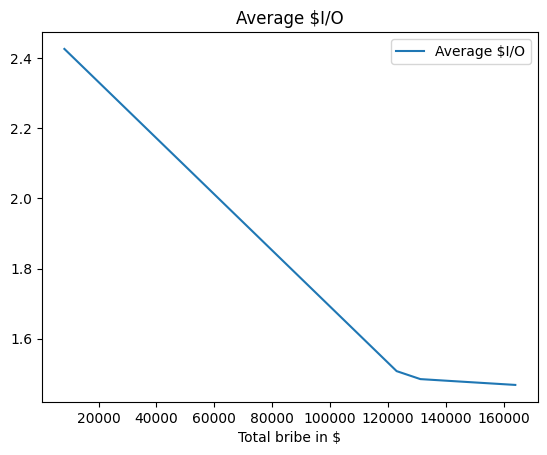

In [46]:
df = pd.DataFrame({
    'Total bribe in $': total_bribes_table,
   'Average $I/O': average_weighed_metrics,
   })
lines = df.plot.line(x="Total bribe in $", y='Average $I/O', title="Average $I/O")